In [1]:
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    SquareLattice,
)
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp
from qiskit_nature.settings import QiskitNatureSettings
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import Optimizer, OptimizerResult, OptimizerState
import psutil

## The Fermi-Hubbard model
The Fermi-Hubbard model is the simplest model describing electrons moving on a lattice and interaction with each other at the same site.
The Hamiltonian is given as follows:

$$
H = \sum_{i, j}\sum_{\sigma = \uparrow, \downarrow} t_{i, j} c_{i, \sigma}^\dagger c_{j, \sigma} + U \sum_{i} n_{i, \uparrow} n_{i, \downarrow},
$$

where $c_{i, \sigma}^\dagger$ and $c_{i, \sigma}$ are creation and annihilation operators of fermion at the site $i$ with spin $\sigma$.
The operator $n_{i, \sigma}$ is the number operator, which is defined by $n_{i, \sigma} = c_{i, \sigma}^\dagger c_{i, \sigma}$. 
The matrix $t_{i, j}$ is a Hermitian matrix called interaction matrix.
The parameter $U$ represents the strength of the interaction.

We can generate the corresponding Hamiltonian of a given lattice using `FermiHubbardModel` class.
Here, we construct the Hamiltonian with uniform interaction and interaction parameters on a two-dimensional lattice.

In [2]:
t = -1.0  # the interaction parameter
v = 0.0  # the onsite potential
u = 5.0

###
### Second Quantized Hamiltonian (Fermi-Hubbard model)
###
square_lattice = SquareLattice(rows=3, cols=2, boundary_condition=BoundaryCondition.PERIODIC)

fhm_square = FermiHubbardModel(
    square_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=u,
)

size = (2, 2, 2)
boundary_condition = (
    BoundaryCondition.PERIODIC,
    BoundaryCondition.PERIODIC,
    BoundaryCondition.PERIODIC,
)
cubic_lattice = HyperCubicLattice(size=size, boundary_condition=boundary_condition)

QiskitNatureSettings.use_pauli_sum_op = False

fhm_cubic = FermiHubbardModel(
    cubic_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=u,
)

ham = fhm_cubic.second_q_op()
print(ham)

Fermionic Operator
number spin orbitals=16, number terms=72
  -1.0 * ( +_0 -_2 )
+ 1.0 * ( -_0 +_2 )
+ -1.0 * ( +_0 -_4 )
+ 1.0 * ( -_0 +_4 )
+ -1.0 * ( +_0 -_8 )
+ 1.0 * ( -_0 +_8 )
+ -1.0 * ( +_8 -_10 )
+ 1.0 * ( -_8 +_10 )
+ -1.0 * ( +_8 -_12 )
+ 1.0 * ( -_8 +_12 )
+ -1.0 * ( +_4 -_6 )
+ 1.0 * ( -_4 +_6 )
+ -1.0 * ( +_4 -_12 )
+ 1.0 * ( -_4 +_12 )
+ -1.0 * ( +_12 -_14 )
+ 1.0 * ( -_12 +_14 )
+ -1.0 * ( +_2 -_6 )
+ 1.0 * ( -_2 +_6 )
+ -1.0 * ( +_2 -_10 )
+ 1.0 * ( -_2 +_10 )
+ -1.0 * ( +_10 -_14 )
+ 1.0 * ( -_10 +_14 )
+ -1.0 * ( +_6 -_14 )
+ 1.0 * ( -_6 +_14 )
+ 0.0 * ( +_0 -_0 )
+ 0.0 * ( +_2 -_2 )
+ 0.0 * ( +_4 -_4 )
+ 0.0 * ( +_6 -_6 )
+ 0.0 * ( +_8 -_8 )
+ 0.0 * ( +_10 -_10 )
+ 0.0 * ( +_12 -_12 )
+ 0.0 * ( +_14 -_14 )
+ -1.0 * ( +_1 -_3 )
+ 1.0 * ( -_1 +_3 )
+ -1.0 * ( +_1 -_5 )
+ 1.0 * ( -_1 +_5 )
+ -1.0 * ( +_1 -_9 )
+ 1.0 * ( -_1 +_9 )
+ -1.0 * ( +_9 -_11 )
+ 1.0 * ( -_9 +_11 )
+ -1.0 * ( +_9 -_13 )
+ 1.0 * ( -_9 +_13 )
+ -1.0 * ( +_5 -_7 )
+ 1.0 * ( -_5 +_7 )
+ -1.0 * ( +_5

To obtain the Hamiltonian in terms of the fermionic operators, we use `second_q_ops` method.
The Hamiltonian is returned as an instance of `FermionicOp`.

- Note
    - The number of fermionic operators required is twice the number of lattice sites because of the spin degrees of freedom.
    - In the implementation, even indexes correspond to up-spin and odd indexes to down-spin.

In [3]:
ham = fhm_cubic.second_q_op().simplify()
print(ham)

Fermionic Operator
number spin orbitals=16, number terms=56
  (-1+0j) * ( +_0 -_2 )
+ (1+0j) * ( -_0 +_2 )
+ (-1+0j) * ( +_0 -_4 )
+ (1+0j) * ( -_0 +_4 )
+ (-1+0j) * ( +_0 -_8 )
+ (1+0j) * ( -_0 +_8 )
+ (-1+0j) * ( +_8 -_10 )
+ (1+0j) * ( -_8 +_10 )
+ (-1+0j) * ( +_8 -_12 )
+ (1+0j) * ( -_8 +_12 )
+ (-1+0j) * ( +_4 -_6 )
+ (1+0j) * ( -_4 +_6 )
+ (-1+0j) * ( +_4 -_12 )
+ (1+0j) * ( -_4 +_12 )
+ (-1+0j) * ( +_12 -_14 )
+ (1+0j) * ( -_12 +_14 )
+ (-1+0j) * ( +_2 -_6 )
+ (1+0j) * ( -_2 +_6 )
+ (-1+0j) * ( +_2 -_10 )
+ (1+0j) * ( -_2 +_10 )
+ (-1+0j) * ( +_10 -_14 )
+ (1+0j) * ( -_10 +_14 )
+ (-1+0j) * ( +_6 -_14 )
+ (1+0j) * ( -_6 +_14 )
+ (-1+0j) * ( +_1 -_3 )
+ (1+0j) * ( -_1 +_3 )
+ (-1+0j) * ( +_1 -_5 )
+ (1+0j) * ( -_1 +_5 )
+ (-1+0j) * ( +_1 -_9 )
+ (1+0j) * ( -_1 +_9 )
+ (-1+0j) * ( +_9 -_11 )
+ (1+0j) * ( -_9 +_11 )
+ (-1+0j) * ( +_9 -_13 )
+ (1+0j) * ( -_9 +_13 )
+ (-1+0j) * ( +_5 -_7 )
+ (1+0j) * ( -_5 +_7 )
+ (-1+0j) * ( +_5 -_13 )
+ (1+0j) * ( -_5 +_13 )
+ (-1+0j) * ( +_13 -_15

Now we embed the Hamiltonian to the Quantum Computer

In [4]:
lmp = LatticeModelProblem(fhm_cubic)

hamiltonian_jw = JordanWignerMapper().map(ham)
# print(np.count_nonzero(hamiltonian_jw - np.diag(np.diagonal(hamiltonian_jw)))
print(hamiltonian_jw)

SparsePauliOp(['IIIIIIIIIIIIIYZY', 'IIIIIIIIIIIIIXZX', 'IIIIIIIIIIIYZZZY', 'IIIIIIIIIIIXZZZX', 'IIIIIIIYZZZZZZZY', 'IIIIIIIXZZZZZZZX', 'IIIIIYZYIIIIIIII', 'IIIIIXZXIIIIIIII', 'IIIYZZZYIIIIIIII', 'IIIXZZZXIIIIIIII', 'IIIIIIIIIYZYIIII', 'IIIIIIIIIXZXIIII', 'IIIYZZZZZZZYIIII', 'IIIXZZZZZZZXIIII', 'IYZYIIIIIIIIIIII', 'IXZXIIIIIIIIIIII', 'IIIIIIIIIYZZZYII', 'IIIIIIIIIXZZZXII', 'IIIIIYZZZZZZZYII', 'IIIIIXZZZZZZZXII', 'IYZZZYIIIIIIIIII', 'IXZZZXIIIIIIIIII', 'IYZZZZZZZYIIIIII', 'IXZZZZZZZXIIIIII', 'IIIIIIIIIIIIYZYI', 'IIIIIIIIIIIIXZXI', 'IIIIIIIIIIYZZZYI', 'IIIIIIIIIIXZZZXI', 'IIIIIIYZZZZZZZYI', 'IIIIIIXZZZZZZZXI', 'IIIIYZYIIIIIIIII', 'IIIIXZXIIIIIIIII', 'IIYZZZYIIIIIIIII', 'IIXZZZXIIIIIIIII', 'IIIIIIIIYZYIIIII', 'IIIIIIIIXZXIIIII', 'IIYZZZZZZZYIIIII', 'IIXZZZZZZZXIIIII', 'YZYIIIIIIIIIIIII', 'XZXIIIIIIIIIIIII', 'IIIIIIIIYZZZYIII', 'IIIIIIIIXZZZXIII', 'IIIIYZZZZZZZYIII', 'IIIIXZZZZZZZXIII', 'YZZZYIIIIIIIIIII', 'XZZZXIIIIIIIIIII', 'YZZZZZZZYIIIIIII', 'XZZZZZZZXIIIIIII', 'IIIIIIIIIIIIIIII', 'IIII

Classical solver

In [5]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(hamiltonian_jw))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

/tmp/ipykernel_9523/577020191.py:1: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  numpy_solver = NumPyMinimumEigensolver()
/tmp/ipykernel_9523/577020191.py:2: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(hamiltonian_jw))


Reference value: -7.41412


VQE See Peruzzo, A., et al, “A variational eigenvalue solver on a quantum processor” arXiv:1304.3061

VQE on Aer qasm simulator (no noise): -3.10791
Delta from reference energy value is 4.30621


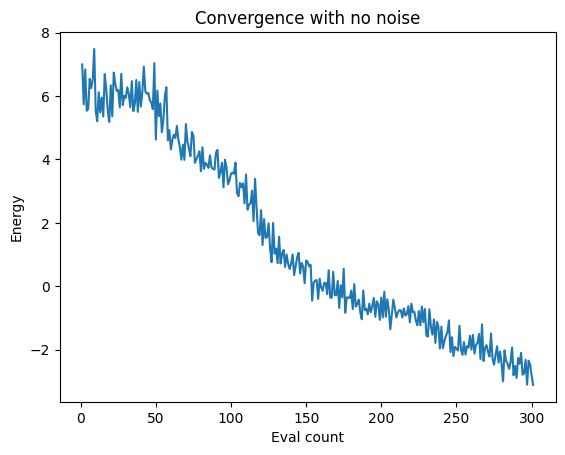

In [6]:
iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
    backend_options={"method": "automatic"}

)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_jw)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)
import matplotlib.pyplot as plt

plt.plot(counts, values)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.title("Convergence with no noise")

plt.show()

Reconstruct the state


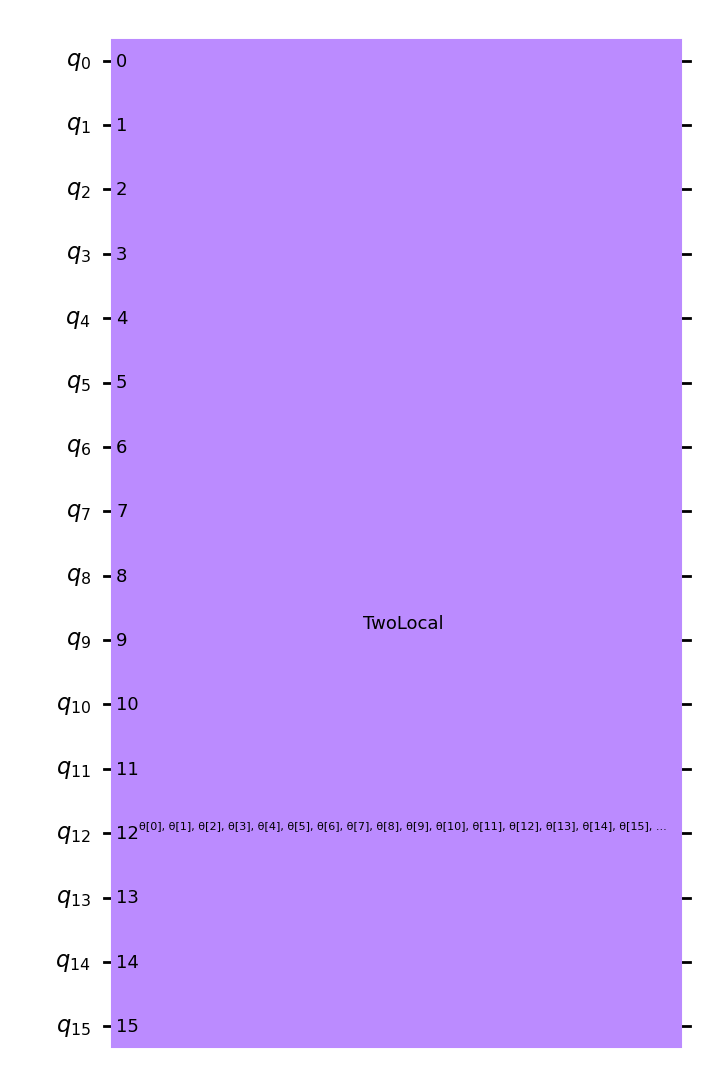

In [7]:
result.optimal_circuit.draw(output='mpl')

Send the optimized circuit to pennylane

In [8]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

In [13]:
dev = qml.device('default.qubit', wires=hamiltonian_jw.num_qubits)
@qml.qnode(dev)
def tomography_circuit(params, **kwargs):
    observables = kwargs.pop("observable")
    qml.from_qiskit(result.optimal_circuit)
    return [qml.expval(o) for o in observables]

A classical shadow is a collection of $N$ individual snapshots $\hat \rho _i$. Each snapshot is obtained with the following procedure:
1. The quantum state $\rho$ is prepared with a circuit.
2. A unitary $U$ is randomly selected from the ensemble and applied to $\rho$
3. A computational basis measurement is performed.
4. The snapshot is recorded as the observed eigenvalue 1,−1 for $|0⟩$,$|1⟩$, respectively, and the index of the randomly selected unitary $U$

To obtain a classical shadow using PennyLane, we design the calculate_classical_shadow function below. This function obtains a classical shadow for the state prepared by an input circuit_template.

In [10]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = circuit_template(params, observable=obs)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)


## State Reconstruction from a Classical Shadow
Classical shadow approximates the exact state that we want to estimate. We can tomographically reconstruct the original quantum state $\rho$ from a classical shadow. Remember that we can approximate $\rho$ by averaging over the snapshots and applying the inverse measurement channel,
$$
\rho = \mathbb{E}\left[\mathcal{M}^{-1}(U^{\dagger}|\hat{b}\rangle\langle\hat{b}|U)\right].
$$

The expectation $\mathbb{E}[⋅]$ describes the average over the measurement outcomes $|b⟩$ and the sampled unitaries. Inverting the measurement channel may seem formidable at first, however, Huang et al. 2 show that for Pauli measurements we end up with a rather convenient expression,

$$
\rho=\mathbb{E}[\hat{\rho}], \quad \text{where} \quad
      \hat{\rho} = \bigotimes_{j=1}^n(3U^{\dagger}_j|\hat{b}_j\rangle\langle\hat{b}_j|U_j-\mathbb{I}).
$$

Here $\hat\rho$ is a snapshot state reconstructed from a single sample in the classical shadow, and $\rho$ is the average over all snapshot states $\hat \rho$ in the shadow.

To implement the state reconstruction of $\rho$ in PennyLane, we develop the shadow_state_reconstruction function.

In [11]:
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.
        obs_list (array): Indices for the applied Pauli measurement.

    Returns:
        Numpy array with the reconstructed snapshot.
    """
    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot


def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots


## Reconstruct minimum state

Construct a classical shadow consisting of 1000 snapshots

In [14]:
num_snapshots = 1000
params = []

shadow = calculate_classical_shadow(
    tomography_circuit, params, num_snapshots, hamiltonian_jw.num_qubits
)
print(shadow[0])
print(shadow[1])

[[1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]]
[[2 0 0 ... 1 2 1]
 [1 0 1 ... 1 2 1]
 [1 1 2 ... 0 0 0]
 ...
 [1 0 2 ... 2 2 2]
 [1 1 0 ... 0 1 1]
 [2 1 1 ... 1 2 2]]


To reconstruct the state we use `shadow_state_reconstruction`.

In [ ]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=6))

Final data

In [ ]:
print(f'Number of qubits: {hamiltonian_jw.num_qubits}')

print('RAM Used (GB):', psutil.virtual_memory()[3] / 1000000000)